## 230523 Starting Metabolomics analysis for spring metabolon experiment
Aim to:
- organize data using the metadata, sort data into vehicle and 2HB, exclude the DEG samples for now
- Conduct differential abundance analysis, enrichment analysis, pathway analysis, hypothesis testing (BCAA metabolism)
- Plot data for final output

In [1471]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

### Data organization
- Data is in two separate files, one for serum and one for muscle. This is because the serum had a greater number of metabolites identified. Keep the analysis parallel for this reason.
- we will want to take the Peak Area Data, because we want to re-do the normalization without the DEG samples
    - We will follow the metabolon analysis method of batch normalization, 
    - imputing a minimum value to empty cells where at least half of the cells are present,
    - and then a natural log transformation
- All serum samples were run in a single batch, all muscle samples were run in a single batch, thus no batch normalization is required

In [1472]:
path = '/Users/brennanwadsworth/Library/CloudStorage/OneDrive-KI.SE/Documents/BJW Experiments/BJW0037_Metabolon 2HB and exercise/UCAM-01-22-VW+/'
muscle_file = 'UCAM-01-22VW+ MUSCLE DATA TABLES'
serum_file = 'UCAM-01-22VW SERUM DATA TABLE'
# metabolite data
serum_df = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Peak Area Data' )
serum_df = serum_df.set_index('PARENT_SAMPLE_NAME')
muscle_df = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Peak Area Data' )
muscle_df = muscle_df.set_index('PARENT_SAMPLE_NAME')
# chemical meta data and chemicals identified to be related to BCAA metabolism
muscle_chemicals = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Chemical Annotation' )
serum_chemicals = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Chemical Annotation' )
sel_chemicals = pd.read_excel(f'{path}selectmetabolites.xlsx',sheet_name='SERUM_named' )
# sample metadata
serum_samples = pd.read_excel(f'{path}{serum_file}.XLSX',sheet_name='Sample Meta Data' )
muscle_samples = pd.read_excel(f'{path}{muscle_file}.XLSX',sheet_name='Sample Meta Data' )
print(muscle_df.shape,'\n', serum_df.shape,'\n',sel_chemicals.shape)

(72, 845) 
 (36, 1071) 
 (953, 5)


serum table has 36 samples and 1071 metabolites

In [1473]:
import re

def fix_chemicals (df_col):
    # goal is to remove all non alpha characters from chemical names so that they do not cause an error in the ANOVA calculation
    # input a dataframe and then column containing the chemicals
    # return a list of new column names to be assigned to a new column in the df
    pattern = r'[0-9]'
    name = list()
    for chem in df_col:
        new_str = re.sub(r'[\W_]', '', chem)
        new_str = re.sub(pattern,"",new_str)
        name.append(new_str)
    return name

muscle_chemicals['NEW_NAME'] = fix_chemicals(muscle_chemicals.PLOT_NAME)
serum_chemicals['NEW_NAME'] = fix_chemicals(serum_chemicals.PLOT_NAME)
sel_chemicals['NEW_NAME'] = fix_chemicals(sel_chemicals.PLOT_NAME)
sel_chemicals['NEW_UNIQUE_NAME'] = fix_chemicals(sel_chemicals.UNIQUE_NAME)

muscle_chemicals.to_csv('muscle_chemicals.csv')
serum_chemicals.to_csv('serum_chemicals.csv')


In [1474]:
serum_df.columns = serum_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
muscle_df.columns = muscle_chemicals.NEW_NAME    # option to change the chemical names to the names instead of code. MAY DISRUPT ANOVA
# df = df.drop(df.iloc[:,776:len(df.columns)],axis=1)
# df.columns = sel_chemicals.NEW_UNIQUE_NAME

# Select the rows in the sample meta data that are either 2HB or Veh, select df to match
muscle_samples_sel = muscle_samples.copy()[muscle_samples.DRUG2 != 'DEG']
muscle_sel = muscle_df.copy()[muscle_df.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
serum_samples_sel = serum_samples.copy()[serum_samples.DRUG2 != 'DEG']
serum_sel = serum_df.copy()[serum_df.index.isin(serum_samples_sel.PARENT_SAMPLE_NAME)]
# select proper gastrocnemius
muscle_samples_sel = muscle_samples.copy()[muscle_samples.GASTROCNEMIUS != 'White']
muscle_sel = muscle_sel.copy()[muscle_sel.index.isin(muscle_samples_sel.PARENT_SAMPLE_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 24 out of 36 rows, correct

# select chemicals of interest
muscle_sel = muscle_sel.copy().loc[:,muscle_sel.columns.isin(sel_chemicals.NEW_NAME)]
serum_sel = serum_sel.copy().loc[:,serum_sel.columns.isin(sel_chemicals.NEW_NAME)]
print(muscle_sel.shape,'\n',serum_sel.shape)
# left with 97 out of 1071 chemicals

(24, 845) 
 (24, 1071)
(24, 620) 
 (24, 953)


In [1475]:
# drop duplicated columns - these are all metabolites we are not interested in
dup = muscle_sel.columns[muscle_sel.columns.duplicated()]
muscle_sel = muscle_sel.drop(dup,axis=1)
dup = serum_sel.columns[serum_sel.columns.duplicated()]
serum_sel = serum_sel.drop(dup,axis=1)

In [1476]:
muscle_na = muscle_sel.dropna(axis=1,thresh=6)
serum_na = serum_sel.dropna(axis=1,thresh=6)
print(f'removed {serum_sel.shape[1] - serum_na.shape[1]} rows in serum file and {muscle_sel.shape[1] - muscle_na.shape[1]} in muscle')

removed 3 rows in serum file and 3 in muscle


In [1477]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))

samples_2HB = muscle_samples[muscle_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
muscle_na['Tx'] = muscle_na.Group.str[0]
muscle_na['Ex'] = muscle_na.Group.str[1]
samples_2HB = serum_samples[serum_samples.DRUG2 != 'DEG'].set_index('PARENT_SAMPLE_NAME')
serum_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
serum_na['Tx'] = serum_na.Group.str[0]
serum_na['Ex'] = serum_na.Group.str[1]



/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/2083384009.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na['Group'] = samples_2HB.loc[:,'GROUP_NAME']
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/2083384009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_na['Tx'] = muscle_na.Group.str[0]
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/2083384009.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [1478]:
# impute based on group values

def impute_by_group(df,grouping_col):
    # calcluate group values
    grouped = df.groupby(grouping_col) # organize data by groups
    holder_df = pd.DataFrame()
    for group in df[grouping_col].unique():
        new_df = grouped.get_group(group)
        new_df = new_df.fillna(new_df.select_dtypes(include=np.number).min())
        holder_df = pd.concat([holder_df,new_df])
    return holder_df


muscle_na = impute_by_group(muscle_na,'Tx')
serum_na = impute_by_group(serum_na,'Tx')


In [1479]:
# impute na with col minimum, create a log-transform df to see if this helps with the probably skewed data
def met_transform(df, scale_by, to_log, standard):
    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns = df.select_dtypes(include=object)
    # function will take a df with index of sample ID and columns of raw metabolite values
    # For now, function will always impoute with column min
    # For now, scale_by will accept either 0 for no scaling, 1 for median scaling, or 2 for mean scaling
    # to_log will accept a 0 for no log transformation, or 1 for natural log transformation
    # standard accepts 0 or 1, if 1 then function will standardize columns
    df = df.drop(object_columns.columns,axis=1).fillna(df.min(axis=0))

    if scale_by == 1:
        df = df.div(df.median())
    elif scale_by == 2:
        df = df.div(df.mean())
    if to_log == 1:
        df = (np.log(df))
    if standard == 1:
        scaler = StandardScaler()
        df_scale = pd.DataFrame(scaler.fit_transform(df))
        df_scale = df_scale.set_index(df.index)
        df_scale.columns = df.columns
        df = df_scale
        df = pd.merge(left=df,right=object_columns,how='left',left_index=True,right_index=True) # add back object columns
    return df



In [1480]:
muscle_log = met_transform(muscle_na,0,1,1)
serum_log = met_transform(serum_na,0,1,1)
muscle_med = met_transform(muscle_na,1,0,1)
serum_med = met_transform(serum_na,1,0,1)


*** Log transformation only improved normality to 67% of columns instead of 59% in the non-transformed data
*** So, we could consider conducting feature-wise normalization of the metabolites, so that we only log transform the columns that benefit from doing so, and then we scale everything to a mean of 0 and SD of 1, 

In [1481]:
def fwn (df1, df2):
    # takes two dataframes of the same size with the same index and selects the columns that are most normally distributed and returns a single df
    # conducts shapiro-wilks test for each column and compares the p values to select optimal method

    # identify columns that are objects instead of numeric, remove and then add back in at the end after caluclations
    object_columns1 = df1.select_dtypes(include=object)
    object_columns2 = df2.select_dtypes(include=object)
    df1 = df1.drop(object_columns1.columns,axis=1)
    df2 = df2.drop(object_columns2.columns,axis=1)

    res1 = list()
    pval1 = list()
    for col in df1.columns:
        shap_test = shapiro(df1.loc[:,col])
        res1.append(shap_test.pvalue > 0.05)
        pval1.append(shap_test.pvalue)
    norm_prop1 = sum(res1)/len(res1)
    res2 = list()
    pval2 = list()
    for col in df2.columns:
        shap_test = shapiro(df2.loc[:,col])
        res2.append(shap_test.pvalue > 0.05)
        pval2.append(shap_test.pvalue)
    norm_prop2 = sum(res2)/len(res2)
    print(f'The propotion of normally distributed columns with method_1 is: {norm_prop1}','\n',
        f'The proportion of normally distributed columns with method_2 is: {norm_prop2}')

    shap_df = pd.DataFrame({'pval1':pval1, 'pval2':pval2})
    shap_df['method_2'] = shap_df.pval2 > shap_df.pval1
    shap_df = shap_df.set_index(df1.columns).T
    df_fwn = df1.drop(shap_df.loc[:,shap_df.loc['method_2',:] == True].columns, axis = 1)
    print(f'take {df_fwn.shape[1]} columns from method 1')
    df_fwn = df_fwn.join(df2.drop(shap_df.loc[:,shap_df.loc['method_2',:] == False].columns, axis = 1), on = 'PARENT_SAMPLE_NAME', how = 'outer')
    print(f'take remaining columns from method 2')
    # object columns are the same between the two, since we are just testing different normalization methods, so only add back one of the object columns
    df_fwn = pd.merge(left = df_fwn, right = object_columns1, how='left',left_index=True,right_index=True) # add back object columns
    return df_fwn


In [1482]:
muscle_fwn = fwn(muscle_med,muscle_log)
serum_fwn = fwn(serum_med,serum_log)

The propotion of normally distributed columns with method_1 is: 0.46110056925996207 
 The proportion of normally distributed columns with method_2 is: 0.7172675521821632
take 156 columns from method 1
take remaining columns from method 2
The propotion of normally distributed columns with method_1 is: 0.5797807551766139 
 The proportion of normally distributed columns with method_2 is: 0.679658952496955
take 343 columns from method 1
take remaining columns from method 2


Feature-wise normalization has improved Shapiro-Wilk nomrliaty test pass rate to 82%, overall a success. Move forward with mean scaling.

In [1483]:
# collect VO2 data and scale
vo2_df = pd.read_csv(f'{path}AVG_dVO2_18mmin.csv')
vo2_df = vo2_df.set_index('PARENT_SAMPLE_NAME')
scaler = StandardScaler()
vo2_scale = pd.DataFrame(scaler.fit_transform(vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1)))
vo2_scale = vo2_scale.set_index(vo2_df.index)
vo2_scale.columns = vo2_df.drop(['MouseID','GASTROCNEMIUS'],axis=1).columns
vo2_scale['MouseID'] = vo2_df['MouseID']
vo2_scale.head()


,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2,MouseID
PARENT_SAMPLE_NAME,,,,,,
UCAM-55688,0.292980,0.448845,0.421998,0.372656,0.177744,VR11
UCAM-55724,-0.223137,0.340126,-0.080347,0.078725,-0.587017,VR42
UCAM-55694,0.595730,0.284979,0.467792,0.225422,0.225418,VR60
UCAM-55730,0.582898,0.616650,0.643768,1.028224,1.079038,VR72
UCAM-55700,-0.535343,0.142384,-0.403397,1.162024,0.996155,VR83


In [1484]:
# add VO2 columns matching by index
muscle_fwn = pd.merge(left = muscle_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
muscle_fwn = muscle_fwn.set_index('MouseID')
muscle_fwn.head()

,oxoadipate,Nformylmethionine,AMP,adenosinediphosphoriboseADPribose,hydroxyphenyllactateHPLA,betaalanine,carnosine,phosphocholine,creatinine,CMP,...,oxindolylalanine,oleylGPCO,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,-0.898487,-0.213275,-1.648874,2.254848,0.141822,0.205568,-0.239184,1.430979,-0.419761,-0.394799,...,1.531046,0.909774,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-0.001298,1.762494,-1.226969,-1.097436,1.148980,-0.484861,-0.041345,-0.222524,0.812293,-0.168142,...,0.086512,2.327244,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
VR60,1.558077,0.667811,0.186239,-0.339834,0.707438,0.106873,0.106709,0.190295,-0.216524,0.362029,...,-0.226376,-0.519412,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418
VS61,1.415637,0.654922,-1.642428,-1.103502,1.040325,-0.178892,-0.461380,-0.442159,0.189852,-1.346150,...,-0.318506,1.255396,VS,V,S,-0.818041,-0.904624,-0.845068,-1.701249,-1.707959
VR83,1.526250,0.037005,-0.017631,0.540531,1.147921,0.314534,0.188298,0.528496,0.032247,0.331392,...,-0.537325,0.628281,VR,V,R,-0.535343,0.142384,-0.403397,1.162024,0.996155


In [1485]:
# add group column to the normalized dataframe, split into Treatment (Tx, V or 2HB) and Exercise (Ex, Sedentary (S) or Run (R))
# add VO2 columns matching by index
serum_fwn = pd.merge(left = serum_fwn, right = vo2_scale,how='left',left_index=True,right_index=True)
serum_fwn = serum_fwn.set_index('MouseID')
serum_fwn.head()

,mevalonate,putrescine,oxoadipate,alphaketoglutarate,hydroxymethylglutarate,hypoxanthine,linoleaten,laurate,NNNtrimethyllysine,glycolatehydroxyacetate,...,NNdimethylpropro,oxindolylalanine,Group,Tx,Ex,avg_dVO2,max_dVO2,AUC,max_VO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
VR11,0.709235,0.685470,0.022642,1.364703,-0.398099,-0.502351,0.270285,-0.496249,1.093857,0.291134,...,-0.260670,0.757551,VR,V,R,0.292980,0.448845,0.421998,0.372656,0.177744
VS23,-0.648186,-1.435921,-1.452872,-1.436328,-1.761484,-0.548995,-1.160317,-1.332863,-0.015677,-2.623574,...,2.510285,2.000349,VS,V,S,-0.818041,-0.904624,-0.845068,-0.826240,-0.671036
VR42,1.517838,-0.269977,0.509308,1.480669,-0.039460,0.242520,-0.416074,0.036625,0.178581,1.170136,...,1.030903,-0.232927,VR,V,R,-0.223137,0.340126,-0.080347,-0.566096,-1.160123
VS43,-0.816439,0.640768,-1.015658,-0.227082,-1.086058,0.887916,0.447118,1.242149,-0.364347,-0.169510,...,-0.428198,-0.239848,VS,V,S,-0.818041,-0.904624,-0.845068,-1.388309,-1.337112
VR60,0.610992,0.281947,0.874911,1.442670,-0.418866,0.640439,-0.289825,-0.678424,0.069408,0.283864,...,0.648689,0.615608,VR,V,R,0.595730,0.284979,0.467792,0.225422,0.225418


In [1486]:
# save data files as csv for other uses
serum_fwn.to_csv('serum_fwn.csv')
muscle_fwn.to_csv('muscle_fwn.csv')

In [1487]:
# conduct basic differential abundance analysis
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import seaborn as sns
from pingouin import ancova

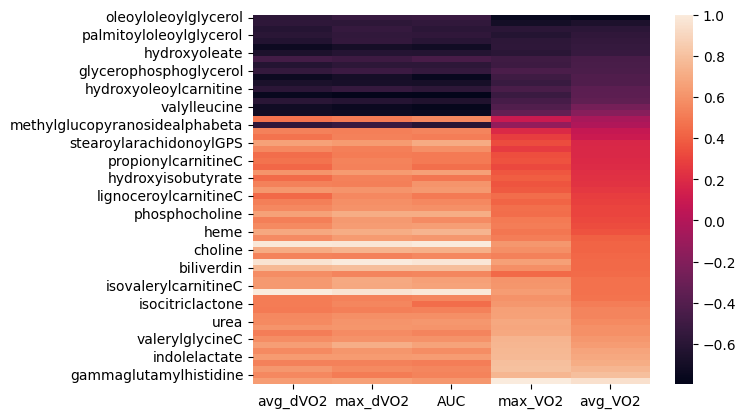

In [1488]:
corr_matrix1 = muscle_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix2 = serum_fwn.drop(['Group','Tx','Ex'],axis=1).corr()
corr_matrix1 = corr_matrix1.drop(corr_matrix1.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
corr_matrix2 = corr_matrix2.drop(corr_matrix2.iloc[:,:-5],axis=1).sort_values(by=['avg_VO2'])
sns.heatmap(corr_matrix1[abs(corr_matrix1.max_dVO2) > 0.5],annot=False)
plt.show()

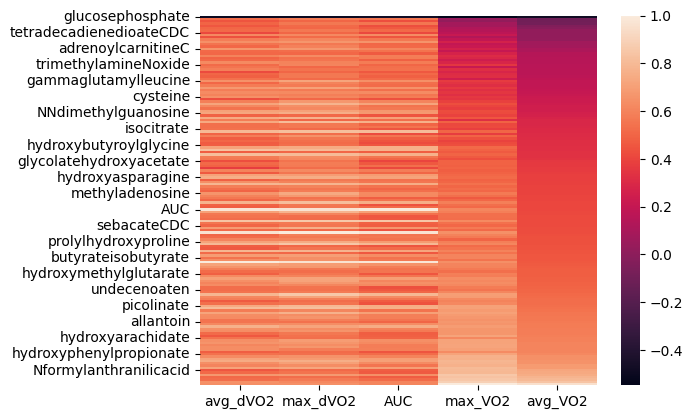

In [1489]:
sns.heatmap(corr_matrix2[abs(corr_matrix2.max_dVO2) > 0.5],annot=False)
plt.show()

## Serum linear model and adjusting means for exercise

*** Conceptualizing linear adjustment for covariates
- Imagine that we want to compare blood pressure in two different cities, but the individuals in each city are different ages
- We know that blood pressure is affected by age, and we are going ot assume in a linear fashion
- We want to convert the blood pressure values to age-adjusted-blood pressure, that is, what the blood pressure would be in each individual adjusting for the age covariate
- We run a linear model (bp ~ age)
- How high or low someones blood pressure is after adjustment for age is the residual value, i.e. the distance from the data-point to the linear regression model, plus the intercept value.
    - The intercept value gives a baseline blood pressure, e.g. 100, and the residual gives the value difference.

In [1490]:
grouped = serum_fwn.groupby('Tx') # organize data by Tx
serum_adj = pd.DataFrame(columns=serum_fwn.columns) # frame for holding adjusted values
covars=['avg_dVO2','avg_VO2']

for met in serum_fwn.columns[:-8]:
    # print(met) # for tracking progress in loop
    # C(Group) tells the model to expect a categorical variable

#    model = ols(formula=f'{met} ~ {covars[0]} + {covars[1]}', data = serum_fwn).fit()
#   serum_adj[met] = model.resid + model.params[0]

     model = ols(formula=f'{met} ~ {covars[1]}', data=grouped.get_group('V')).fit()
     hb_adj = grouped.get_group('H')[met] - model.predict(grouped.get_group('H')) + model.params[0]
     veh_adj = model.resid + model.params[0]
     serum_adj[met] = pd.concat([hb_adj,veh_adj],axis=0)

serum_adj['Group'] = serum_fwn['Group']
serum_adj['Tx'] = serum_fwn['Tx']
serum_adj['Ex'] = serum_fwn['Ex']
serum_adj['avg_VO2'] = serum_fwn['avg_VO2']
serum_adj['avg_dVO2'] = serum_fwn['avg_dVO2']
serum_adj = serum_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
serum_adj.to_csv('serum_adjusted_values.csv')


In [1491]:
serum_adj.head(10)

,mevalonate,putrescine,oxoadipate,alphaketoglutarate,hydroxymethylglutarate,hypoxanthine,linoleaten,laurate,NNNtrimethyllysine,glycolatehydroxyacetate,...,ditertbutylphenol,cismethyleneheptanoylglycine,neopentylglycolazelate,NNdimethylpropro,oxindolylalanine,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
HR40,0.961055,1.339948,1.848148,0.948085,1.378225,0.646750,1.304593,2.113540,1.363222,1.193955,...,0.744936,1.435272,2.261851,0.359125,-0.290240,HR,H,R,1.622066,-0.585547
HS41,1.195863,1.164209,0.285384,-0.126191,-0.139992,0.922995,-0.659221,0.099720,2.717684,0.992383,...,-0.274242,-0.239035,-0.320348,2.428124,1.419550,HS,H,S,-0.550738,-0.537709
HR52,-1.061639,1.094337,1.451457,1.153065,0.653748,0.740081,0.204232,-0.357726,-0.107987,1.036017,...,1.053979,0.956780,-0.851728,-0.477895,-0.077495,HR,H,R,0.496940,0.196349
HS53,-1.382583,-0.523949,-0.574589,-1.416726,0.213727,-0.560337,0.413675,-0.273203,1.261867,0.582470,...,0.816073,-0.115825,-0.201357,0.553916,0.936438,HS,H,S,-0.550738,-1.238012
HR70,0.448823,0.897825,0.250333,0.403761,-0.154480,0.669749,1.164304,0.695658,0.457924,-0.013126,...,-1.011666,0.915088,-1.188839,0.605289,1.094919,HR,H,R,1.450905,0.939831
HS71,-0.831594,1.016471,-0.430664,0.531647,-0.338405,1.441426,0.762571,0.185718,-0.328988,-0.893979,...,-0.008784,-0.041251,-1.013596,-0.384308,0.640082,HS,H,S,-0.550738,0.553341
HR81,1.011972,-0.023959,0.119236,0.959181,-0.590557,-1.469548,1.006343,0.784747,-0.122053,-1.427189,...,0.608702,0.751892,0.357538,-0.102030,-0.582594,HR,H,R,0.761212,0.854730
HS82,0.515100,0.688703,-0.325155,-0.730848,0.760651,-0.281476,-0.617148,-0.744364,-0.081867,-0.161737,...,0.359945,0.379938,-0.939175,-0.588619,0.971935,HS,H,S,-0.550738,0.389210
HR92,-0.164431,-0.281202,0.408788,1.500093,1.223693,1.151936,-0.027555,0.093051,-0.202589,0.098518,...,0.653615,0.216689,-0.536320,-0.454122,-0.316817,HR,H,R,0.556003,-0.499269


### Serum group comparisons

In [1492]:
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in serum_adj.columns[:-8]:
    ancova_res = ancova(data=serum_fwn, dv = met, covar = 'avg_VO2', between = 'Tx')
    p_value = ancova_res.iloc[0,4]
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('serum_FDR.csv')
mus_hit_results = results.sort_values('p_value').head(50)
serum_fwn_DE = serum_fwn[mus_hit_results.Metabolite.unique()]
serum_DE = serum_adj[mus_hit_results.Metabolite.unique()]
serum_DE['Group'] = serum_adj['Group']
serum_fwn_DE['Group'] = serum_adj['Group']
print(results.reject.value_counts(),'\n',serum_adj.shape, serum_DE.shape)


reject
False    758
True      60
Name: count, dtype: int64 
 (24, 826) (24, 51)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/1531413367.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serum_DE['Group'] = serum_adj['Group']
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/1531413367.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  serum_fwn_DE['Group'] = serum_adj['Group']


In [1493]:
"""
grouped = serum_adj.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in serum_adj.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, HR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, HS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('serum_FDR.csv')
ser_hit_results = results[results.reject == True]
serum_DE = serum_adj[ser_hit_results.Metabolite.unique()]
serum_DE['Group'] = serum_adj['Group']
print(results.reject.value_counts(),'\n',serum_adj.shape, serum_DE.shape)
"""

"\ngrouped = serum_adj.groupby('Group') # organize data by groups\nresults = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results\n# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe\nfor met in serum_adj.columns[:-8]:\n    VS = grouped.get_group('VS')[met]\n    VR = grouped.get_group('VR')[met]\n    HS = grouped.get_group('HS')[met]\n    HR = grouped.get_group('HR')[met]\n    #perform test\n    test_stat, p_value = ttest_ind(VR, HR)\n    # append data to the results table\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'R'\n        })\n    test_stat, p_value = ttest_ind(VS, HS)\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'S'\n        })\n    \nreject, adj_pvalues, sidak, bonf = multipletests(\n    results.p_value.fillna(1), alpha=0.1, m

In [1494]:
serum_DE.head()


,hydroquinonesulfate,methylnaphthylsulfate,xanthosine,adipoylcarnitineCDC,palmitoyldocosahexaenoylGPC,tricosanoylsphingomyelind,eicosenoylcarnitineC,SRdihydroxybutyrate,itaconate,quinate,...,undecenoaten,ursodeoxycholate,Nacetylpyrraline,acetamidobenzoate,linoleoyldocosahexaenoylGPC,behenoyldihydrosphingomyelind,succinate,nicotinamideriboside,arachidonoylGPCn,Group
MouseID,,,,,,,,,,,,,,,,,,,,,
HR40,-0.887403,0.761374,0.277753,1.931128,1.473160,1.872585,1.584608,1.281140,1.569633,-0.900126,...,1.738522,0.384834,-0.705573,-0.071839,1.414911,1.754142,0.057926,-0.178997,0.899101,HR
HS41,-0.906452,0.735046,0.601658,0.355406,-0.567269,0.692676,1.002210,0.928437,0.587940,0.572011,...,0.370639,0.373495,0.981446,0.449918,0.202422,0.546913,0.263085,0.802324,-0.058214,HS
HR52,-1.198759,0.331062,1.444762,1.193174,0.623943,0.423079,1.758526,-0.238424,0.244899,-1.200105,...,-0.024890,0.228518,-0.977177,-1.153884,-0.110693,0.619146,0.842986,0.811597,1.244819,HR
HS53,-0.627587,1.120453,0.436928,0.658091,0.873661,-0.049054,-0.005808,-0.200644,0.028164,-0.649804,...,-0.723069,0.667108,-0.478930,-0.326294,0.059332,0.084003,0.342777,0.470931,1.123337,HS
HR70,-0.375877,0.094478,0.675539,0.723078,0.293664,0.970178,0.869893,0.926100,0.309116,-1.485346,...,1.157725,0.095918,-1.235436,-0.247586,-0.111665,0.596731,0.442426,-0.520928,0.190831,HR


## Muscle Linear model adjusting values for exercise 

In [1495]:
muscle_adj = pd.DataFrame(columns=muscle_fwn.columns) # frame for holding adjusted values
covars=['avg_dVO2','avg_VO2','glucosephosphate_ser']
muscle_anc = muscle_fwn.copy()
muscle_anc['glucosephosphate_ser'] = serum_fwn['glucosephosphate']
grouped = muscle_anc.groupby('Tx') # organize data by Tx

for met in muscle_anc.columns[:-9]:
    # print(met) # for tracking progress in loop
    model = ols(formula=f'{met} ~ {covars[0]} + {covars[1]}', data=grouped.get_group('V')).fit()
    # C(Group) tells the model to expect a categorical variable

    hb_adj = grouped.get_group('H')[met] - model.predict(grouped.get_group('H')) + model.params[0]
    veh_adj = model.resid + model.params[0]

    muscle_adj[met] = pd.concat([hb_adj,veh_adj],axis=0)

muscle_adj['Group'] = muscle_fwn['Group']
muscle_adj['Tx'] = muscle_fwn['Tx']
muscle_adj['Ex'] = muscle_fwn['Ex']
muscle_adj['avg_VO2'] = muscle_fwn['avg_VO2']
muscle_adj['avg_dVO2'] = muscle_fwn['avg_dVO2']
muscle_adj = muscle_adj.drop(['max_dVO2','max_VO2','AUC'],axis=1)
muscle_adj.to_csv('muscle_adjusted_values.csv')


In [1496]:
muscle_adj.head()

,oxoadipate,Nformylmethionine,AMP,adenosinediphosphoriboseADPribose,hydroxyphenyllactateHPLA,betaalanine,carnosine,phosphocholine,creatinine,CMP,...,Nacetylaminoadipate,ditertbutylphenol,NNdimethylpropro,oxindolylalanine,oleylGPCO,Group,Tx,Ex,avg_dVO2,avg_VO2
MouseID,,,,,,,,,,,,,,,,,,,,,
HR40,-1.467669,0.604020,1.155266,0.554374,0.509589,-1.682942,-0.081640,-2.183583,0.550942,0.501047,...,-1.129802,-2.074813,-0.420198,-2.253050,0.949912,HR,H,R,1.622066,-0.585547
HS41,0.085550,0.282551,-0.764491,0.289759,0.478822,0.165740,0.494791,0.903193,0.654324,-0.336464,...,1.125629,0.246050,0.937291,1.490677,0.342371,HS,H,S,-0.550738,-0.537709
HR70,0.812456,1.735956,1.902503,-1.354648,0.655030,-0.986382,-0.271350,-0.577402,-0.863437,0.522988,...,-0.734704,-0.781902,0.299352,-1.856883,-0.588613,HR,H,R,1.450905,0.939831
HS71,-0.129955,0.029822,-1.212639,0.346962,-0.442697,0.378337,0.424791,0.589748,-0.003786,-1.033751,...,0.693797,0.200227,-0.967063,2.084438,-0.286319,HS,H,S,-0.550738,0.553341
HR92,0.341596,-0.080949,1.064611,-1.072894,0.630093,2.124104,-0.199274,0.007674,0.149239,1.030852,...,0.525386,-0.173917,-0.767051,-1.005226,0.647059,HR,H,R,0.556003,-0.499269


### Muscle group comparisons and testing

In [1497]:
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_adj.columns[:-8]:
    ancova_res = ancova(data=muscle_anc, dv = met, covar = 'max_VO2', between = 'Tx')
    p_value = ancova_res.iloc[0,4]
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('muscle_FDR.csv')
mus_hit_results = results.sort_values('p_value').head(25)
muscle_DE = muscle_adj[mus_hit_results.Metabolite.unique()]
muscle_fwn_DE = muscle_fwn[mus_hit_results.Metabolite.unique()]
muscle_DE['Group'] = muscle_adj['Group']
muscle_fwn_DE['Group'] = muscle_adj['Group']
print(results.reject.value_counts(),'\n',muscle_adj.shape, muscle_DE.shape)

reject
False    520
True       4
Name: count, dtype: int64 
 (24, 532) (24, 26)


/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/4214195792.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_DE['Group'] = muscle_adj['Group']
/var/folders/8r/1g2k_06939jf0qv8bqn5v9040000gn/T/ipykernel_26559/4214195792.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  muscle_fwn_DE['Group'] = muscle_adj['Group']


In [1498]:
mus_hit_results

,Metabolite,p_value,Ex,adj_p,reject
107,oxoarginine,0.000002,R,0.000869,True
67,methylcytidine,0.000054,R,0.013930,True
352,myristoylglycerol,0.00061,R,0.090767,True
420,daidzeinsulfate,0.000698,R,0.090767,True
194,ornithine,0.004185,R,0.435190,False
400,imidazolepropionate,0.007251,R,0.506932,False
235,erucaten,0.008757,R,0.506932,False
303,Nacetylphenylalanine,0.009658,R,0.506932,False
233,Nacetylleucine,0.010268,R,0.506932,False
203,valine,0.010799,R,0.506932,False


In [1499]:
""" t test FDR
grouped = muscle_fwn.groupby('Group') # organize data by groups
results = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results
# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe
for met in muscle_fwn.columns[:-8]:
    VS = grouped.get_group('VS')[met]
    VR = grouped.get_group('VR')[met]
    HS = grouped.get_group('HS')[met]
    HR = grouped.get_group('HR')[met]
    #perform test
    test_stat, p_value = ttest_ind(VR, HR)
    # append data to the results table
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'R'
        })
    test_stat, p_value = ttest_ind(VS, HS)
    results.loc[len(results)] = pd.Series({
        'Metabolite': met,
        'p_value': p_value,
        'Ex': 'S'
        })
    
reject, adj_pvalues, sidak, bonf = multipletests(
    results.p_value.fillna(1), alpha=0.1, method = 'fdr_tsbh'
)
results['adj_p'] = adj_pvalues
results['reject'] = reject
results.to_csv('muscle_FDR.csv')
mus_hit_results = results[results.p_value <= 0.05]
muscle_DE = muscle_fwn[mus_hit_results.Metabolite.unique()]
muscle_DE['Group'] = muscle_fwn['Group']
print(results.reject.value_counts(),'\n',muscle_fwn.shape, muscle_DE.shape)
"""


" t test FDR\ngrouped = muscle_fwn.groupby('Group') # organize data by groups\nresults = pd.DataFrame(columns=['Metabolite','p_value','Ex']) # create an empty dataframe to hold the results\n# iterate over each column, calculating the test statistic for each column and storing the results in the dataframe\nfor met in muscle_fwn.columns[:-8]:\n    VS = grouped.get_group('VS')[met]\n    VR = grouped.get_group('VR')[met]\n    HS = grouped.get_group('HS')[met]\n    HR = grouped.get_group('HR')[met]\n    #perform test\n    test_stat, p_value = ttest_ind(VR, HR)\n    # append data to the results table\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'R'\n        })\n    test_stat, p_value = ttest_ind(VS, HS)\n    results.loc[len(results)] = pd.Series({\n        'Metabolite': met,\n        'p_value': p_value,\n        'Ex': 'S'\n        })\n    \nreject, adj_pvalues, sidak, bonf = multipletests(\n    results.p_value.fillna(1),

In [1500]:
mus_hit_results

,Metabolite,p_value,Ex,adj_p,reject
107,oxoarginine,0.000002,R,0.000869,True
67,methylcytidine,0.000054,R,0.013930,True
352,myristoylglycerol,0.00061,R,0.090767,True
420,daidzeinsulfate,0.000698,R,0.090767,True
194,ornithine,0.004185,R,0.435190,False
400,imidazolepropionate,0.007251,R,0.506932,False
235,erucaten,0.008757,R,0.506932,False
303,Nacetylphenylalanine,0.009658,R,0.506932,False
233,Nacetylleucine,0.010268,R,0.506932,False
203,valine,0.010799,R,0.506932,False


### Clustering

In [1501]:
import seaborn as sns

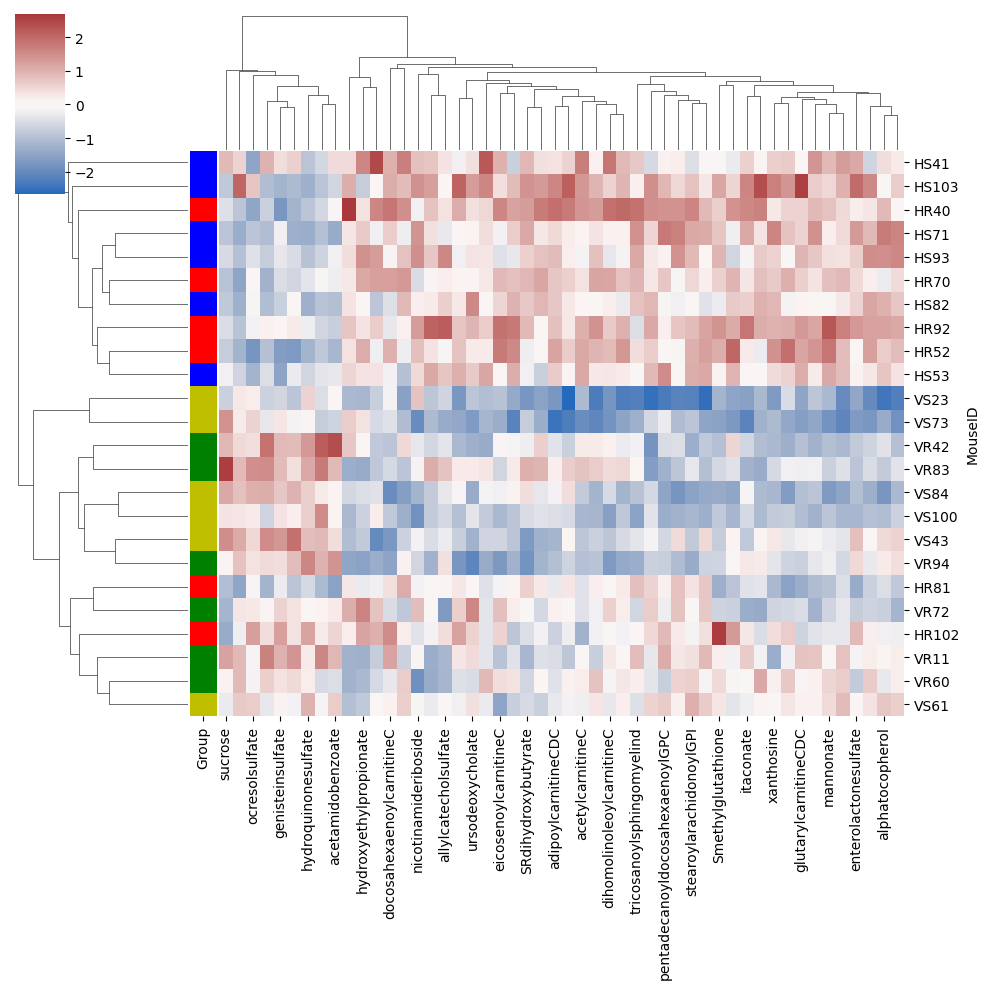

In [1502]:
lut = dict(zip(serum_DE.Group.unique(), "rbgy"))
row_colours =  serum_DE.Group.map(lut)
sns.clustermap(serum_DE.select_dtypes(include=np.number),row_colors=row_colours,cmap='vlag',method='average',metric='euclidean')

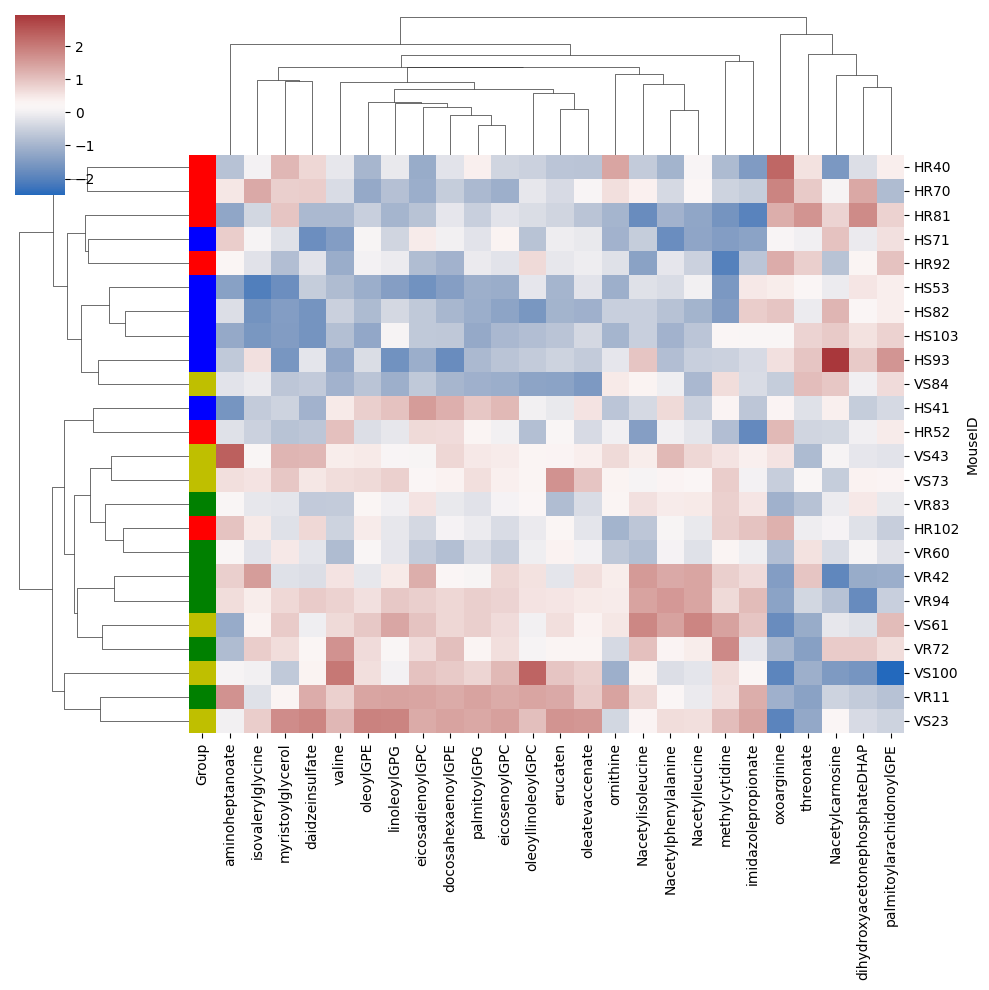

In [1503]:
lut = dict(zip(muscle_DE.Group.unique(), "rbgy"))
row_colours =  muscle_DE.Group.map(lut)
sns.clustermap(muscle_DE.select_dtypes(include=np.number),row_colors=row_colours,cmap='vlag',method='average',metric='Seuclidean')

## Over-representation analysis

In [1504]:
from scipy.stats import hypergeom


plan is to take the muscle_DE and serum_DE and check for over-representation of any of the matabolic sub_pathways (e.g. BCAA degradation instead of super_pathway 'amino acid')

Recall the concept: there is a bucket of M balls, consisting of (n) black and (M-n) white balls. We select N balls without replacement, and want to calculate the probability distribution for black ball selection. E.g., what is the probability of selecting at least k balls, gives p value.
For us, in a pool of ~1000 metabolites, ~ 40 are related to BCAA metabolism, if ~ 200 metabolites are differentially abundant, what is the probability that x metabolites from BCAA metabolism are significant? If less than 0.05, ***

can calculate fold enrichment, in form of observed/expected  - > (differentially abundant BCAA / total differentially abundant) / (BCAA/total)

In [1505]:
def Over_rep(df,chem_df):
    # plan to take the hit_results df. Find the Metabolite in the chemicals df under NEW_NAME. conduct appropriate enrichment analyses
    hit_set = set(df.Metabolite) # all significant metabolites, i.e. total balls drawn from bucket
    N = len(hit_set)
    M = len(set(chem_df.NEW_NAME)) # all chemicals assessed, i.e. total balls in bucket
    pathways = set(chem_df.SUB_PATHWAY) # all pathways
    scores = pd.DataFrame(columns=['Pathway','Enrichment_Score','p_value'])
    for pathway in pathways:
        metabolite_set = set(chem_df[chem_df.SUB_PATHWAY == pathway]['NEW_NAME']) # total chemicals in pathway of interest, i.e. count of black balls
        match_set = set.intersection(metabolite_set,hit_set) # chemicals in path of interest that are significant, i.e. number of black balls drawn out of bucket
        [k, n] = [len(match_set), len(metabolite_set)]
        # print(pathway,'\n',match_set)
        enrichment_score = (k/N)/(n/M) # fold enrichment
        hg = hypergeom(M, n, N)
        p_value = hg.sf(k) # probability of having this many, or more, hits in the pathway of interest 
        scores.loc[len(scores)] = pd.Series({
            'Pathway':pathway,
            'Enrichment_Score':enrichment_score,
            'p_value':p_value
        })
    return scores

In [1506]:
mus_ORA = Over_rep(mus_hit_results[mus_hit_results.Ex == 'R'],sel_chemicals[sel_chemicals.SUPER_PATHWAY == 'Amino Acid'])
mus_ORA.sort_values(by='p_value')

,Pathway,Enrichment_Score,p_value
5,Phenylalanine Metabolism,2.04,0.074276
12,Guanidino and Acetamido Metabolism,0.0,0.230609
10,"Leucine, Isoleucine and Valine Metabolism",1.165714,0.24357
9,Histidine Metabolism,0.906667,0.383231
6,Creatine Metabolism,0.0,0.409683
0,Urea cycle; Arginine and Proline Metabolism,0.68,0.590182
2,Alanine and Aspartate Metabolism,0.0,0.655466
8,Glutathione Metabolism,0.0,0.655466
11,Polyamine Metabolism,0.0,0.655466
7,"Glycine, Serine and Threonine Metabolism",0.0,0.737948


In [1507]:
ser_ORA = Over_rep(ser_hit_results[ser_hit_results.Ex == 'R'],sel_chemicals)
ser_ORA.sort_values(by='p_value')

,Pathway,Enrichment_Score,p_value
21,Lysoplasmalogen,31.285714,0.000326
73,Food Component/Plant,9.733333,0.00049
5,Urea cycle; Arginine and Proline Metabolism,9.125,0.004177
64,Modified Peptides,0.0,0.004566
69,Drug - Other,0.0,0.004566
...,...,...,...
101,"Methionine, Cysteine, SAM and Taurine Metabolism",0.0,0.101125
89,"Leucine, Isoleucine and Valine Metabolism",0.0,0.122053
95,"Fatty Acid, Dicarboxylate",0.0,0.134432
19,Lysophospholipid,0.0,0.154774


In [1508]:
M = 20
N = 12
n = 7
k = 5


hg = hypergeom(M,n,N)
hg.sf(k)

0.10557275541795666